In [33]:
import os
import matplotlib.pyplot as plt
import cv2
import pytesseract
import re
from threading import Thread

***

# Part 1: Preprocess License Plate

In [34]:
# Path to Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [35]:
# STEP 1: LOAD IMAGE ================================
# Load image plate from predict_car_license_plate/output
# This folder contains images after prediction of car license plate 
image_folder_path = 'data/predict_car_license_plate/output'
# List all image files in the folder
image_files = os.listdir(image_folder_path)

In [36]:
# Receive the image load from CV2 and show it with Matplotlib
def showImgCv2Plt(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [37]:
# Get 1 image from the list of image files
img_path = os.path.join(image_folder_path, image_files[0])
# open image with cv2 in Grayscale
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

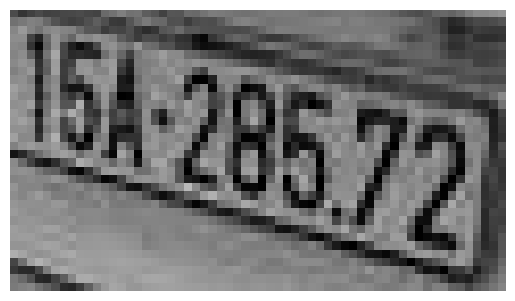

In [38]:
# Show Image
showImgCv2Plt(image)

In [39]:
# STEP 2: RESIZE IMAGE FOR BETTER FEATURE VISIBILITY ================================
# The image of license plate is too small in some case, so we need to resize it to fixed size for better OCR result
# Resize the image to 250x50 
# Interpolation: It refers to the method used to estimate pixel values at non-integer coordinates during resizing or transformations (e.g., scaling, rotating, or warping an image).
# cv2.INTER_CUBIC: This specific interpolation method uses cubic convolution to calculate the values of the new pixels. It takes into account the values of 16 neighboring pixels (4x4 grid) around the pixel being calculated.
gray = cv2.resize(image, (250, 50), interpolation=cv2.INTER_CUBIC)

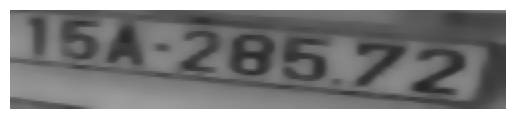

In [40]:
# STEP 3: APPLY MEDIAN BLUR and EDGE PRESERVING FILTER TO REMOVE NOISE ===================
img_clear = cv2.medianBlur(gray, 3)
img_clear = cv2.edgePreservingFilter(img_clear, sigma_s=5)
showImgCv2Plt(img_clear)

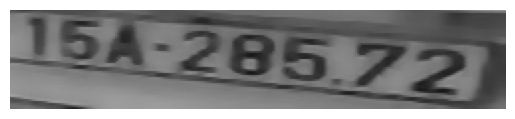

In [41]:
# STEP 4: APPLY GAUSSIAN BLUR TO SHARPEN THE IMAGE ==========================
# Sharpen the image using GaussianBlur
gaussian = cv2.GaussianBlur(img_clear, (5, 5), 2)
sharpened = cv2.addWeighted(img_clear, 2, gaussian, -1, 0)
showImgCv2Plt(sharpened)

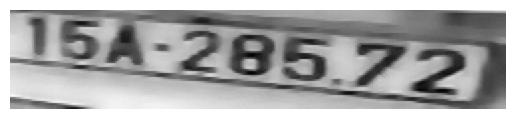

In [42]:
# STEP 5: INCREASE CONTRAST ==========================
# Stretch the pixel values
enhanced = cv2.normalize(sharpened, None, 0, 255, cv2.NORM_MINMAX)
showImgCv2Plt(enhanced)


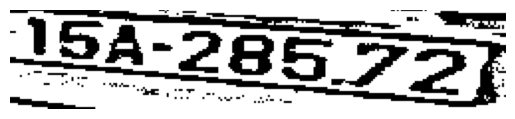

In [43]:
# STEP 6: ADAPTIVE THRESHOLDING TO CONVERT TO BLACK-WHITE IMAGE ==========================
# This step converts the image into a binary format using adaptive Gaussian thresholding, which preserves important details and removes background noise. 
# This method is especially effective for processing documents or images with uneven lighting.

enhanced = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
showImgCv2Plt(enhanced)

In [44]:
# FUNCTION TO PREPROCESS LICENSE PLATE IMAGE ==========================
def preprocess_license_plate(plate_image):
    """
    Preprocess the cropped license plate image for better OCR results.
    :param plate_image: Cropped license plate image (numpy array)
    :return: Preprocessed image ready for OCR (numpy array)
    """
    try:
        try:
            # Step 1: Convert to grayscale
            gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
        except:
            gray = plate_image

        # Step 2: Resize image for better feature visibility
        gray = cv2.resize(gray, (250, 50), interpolation=cv2.INTER_CUBIC)

        # Step 3: Apply Median Blur and Edge Preserving Filter
        img_clear = cv2.medianBlur(gray, 3)
        img_clear = cv2.edgePreservingFilter(img_clear, sigma_s=5)

       # Step 4: Sharpen the image using GaussianBlur
        gaussian = cv2.GaussianBlur(img_clear, (5, 5), 2)
        sharpened = cv2.addWeighted(img_clear, 2, gaussian, -1, 0)

        # Step 5: Increase contrast
        
        # Stretch the pixel values
        contrast = cv2.normalize(sharpened, None, 0, 255, cv2.NORM_MINMAX)
        
        # Step 6: Adaptive Thresholding
        enhanced = cv2.adaptiveThreshold(contrast, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        

        return enhanced

    except Exception as e:
        print("Error during license plate preprocessing:", e)
        return None

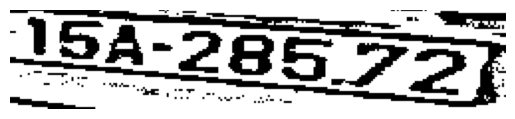

In [45]:
# Preprocess the image
preprocessed_image = preprocess_license_plate(image)
showImgCv2Plt(preprocessed_image)

***

# Part 2: Predict License Text

In [46]:
# Create Thread to rotate image from -4 to 4 degree and preprocess it
def rotate_image(image, angle):
    """
    Rotate the image by a custom angle.
    :param image: Input image (numpy array)
    :param angle: Rotation angle in degrees
    :return: Rotated image (numpy array)
    """
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image


In [47]:
from collections import Counter

# Clean the text extracted from the image to remove invalid characters
# Only keep uppercase letters, digits, and hyphens\
# Remove leading and trailing hyphens
# Remove surrounding whitespace
def clean_text(text, min_length=0, max_length=11):
    if not text:
        return ""
    text = re.sub(r'[^A-Z0-9\-]', '', text)  # Keep only valid characters
    text = re.sub(r'^[\-]+', '', text)  # Remove leading . or -
    text = re.sub(r'[\-]+$', '', text)  # Remove trailing . or -
    text = text.strip()  # Remove surrounding whitespace
    if len(text) < min_length or len(text) > max_length:
        return ""
    return text


# Get the most frequent element in a list Exapmle: [1, 2, 2, 3, 3, 3, 4] => 3
def get_most_frequency(list):
    frequency = Counter(list)
    return frequency.most_common(1)[0][0]
    
#=== PREDICT LICENSE TEXT ======================================== 
def predict_license_text(image):
    if image is None:
        print("Image is None")
        return None
    else:
        # Extract text from the original image
        text = pytesseract.image_to_string(image).strip()
        text = clean_text(text)
        # If no text or too short, try rotated versions
        if text == "" or len(text) < 3:
            texts = []  # Store text from rotated images
            
            def worker(angle):
                rotated_image = rotate_image(image, angle)
                text = pytesseract.image_to_string(rotated_image).strip()
                text = clean_text(text)
                if text:
                    texts.append(text)
            
            threads = []
            for angle in range(-5, 6):  # Try rotations from -4 to +4 degrees
                thread = Thread(target=worker, args=(angle,))
                thread.start()
                threads.append(thread)
            
            for thread in threads:
                thread.join()
            final_text = ''

            # get most frequent length of text 
            if len(texts) == 0:
                return ""
            text_lenghs = [len(text) for text in texts if len(text) > 2]
            final_length = get_most_frequency(text_lenghs)


            for i in range(final_length):
                char =  [text[i] for text in texts if i < len(text)]
                final_text += get_most_frequency(char) or ""
            return final_text
        return text

            

License plate:  5A-26572


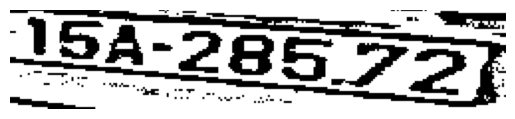

In [48]:
print("License plate: ", predict_license_text(preprocessed_image))
showImgCv2Plt(preprocessed_image)